In [7]:
# nlp_decade_classifier.py

import pandas as pd
import numpy as np
import unicodedata
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

In [8]:
# ==========================
# 1) Preprocesamiento
# ==========================
def clean_text(text: str) -> str:
    """Normaliza, convierte a minúsculas y elimina caracteres especiales."""
    text = unicodedata.normalize("NFKC", str(text))
    text = text.lower()
    text = re.sub(r"\d+", " ", text)  # quitar números
    text = re.sub(r"[^\w\s]", " ", text)  # quitar signos de puntuación
    text = re.sub(r"\s+", " ", text).strip()  # espacios múltiples
    return text

# ==========================
# 2) Cargar datos de entrenamiento
# ==========================
df = pd.read_csv("train.csv")   # columnas: text, decade
df = df.dropna(subset=["text", "decade"]).reset_index(drop=True)
df["text_clean"] = df["text"].apply(clean_text)
df["decade"] = df["decade"].astype(int)

X = df["text_clean"].values
y = df["decade"].values

# Dividir en train/test interno (para comparar modelos)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# ==========================
# 3) Vectorizadores (word + char)
# ==========================
word_tfidf = TfidfVectorizer(
    analyzer="word", ngram_range=(1, 3), max_df=0.95, min_df=2, max_features=100000
)
char_tfidf = TfidfVectorizer(
    analyzer="char", ngram_range=(3,6), max_df=0.95, min_df=2, max_features=50000
)

features = FeatureUnion([
    ("word", word_tfidf),
    ("char", char_tfidf)
])


In [10]:
# ==========================
# 4) Definir modelos y grids
# ==========================
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=5000, class_weight="balanced", solver="liblinear"
    ),
    "LinearSVC": LinearSVC(
        max_iter=5000, class_weight="balanced", random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        class_weight="balanced", random_state=42, n_jobs=-1
    )
}

param_grids = {
    "LogisticRegression": {"clf__C": [0.1, 1, 5]},
    "LinearSVC": {"clf__C": [0.1, 1, 5]},
    "RandomForest": {"clf__n_estimators": [100, 300], "clf__max_depth": [10, 20]}
}

In [11]:
# ==========================
# 5) Entrenamiento y evaluación
# ==========================
results = {}
best_model = None
best_score = 0
best_name = None

for name, model in models.items():
    print(f"\n=== Entrenando {name} ===")
    pipeline = Pipeline([
        ("features", features),
        ("clf", model)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grids[name],
        cv=3,
        n_jobs=-1,
        scoring="f1_macro"
    )
    grid.fit(X_train, y_train)

    print("Mejores parámetros:", grid.best_params_)

    y_pred = grid.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f"{name} -> Accuracy={acc:.4f}, F1_macro={f1:.4f}")
    print("\nReporte por clase:\n", classification_report(y_test, y_pred))

    results[name] = {"acc": acc, "f1": f1, "model": grid.best_estimator_}

    if f1 > best_score:
        best_score = f1
        best_model = grid.best_estimator_
        best_name = name



=== Entrenando LogisticRegression ===
Mejores parámetros: {'clf__C': 5}
LogisticRegression -> Accuracy=0.2512, F1_macro=0.2458

Reporte por clase:
               precision    recall  f1-score   support

         150       0.75      0.71      0.73       157
         151       0.47      0.73      0.57       162
         152       0.62      0.56      0.59       157
         153       0.45      0.61      0.52       155
         154       0.50      0.56      0.53       166
         155       0.34      0.28      0.31       167
         156       0.32      0.37      0.35       158
         157       0.24      0.24      0.24       166
         158       0.24      0.29      0.27       156
         159       0.24      0.26      0.25       160
         160       0.12      0.11      0.12       170
         161       0.14      0.12      0.13       157
         162       0.16      0.17      0.17       162
         163       0.18      0.16      0.17       166
         164       0.17      0.17      0


=== Mejor modelo: LogisticRegression con F1_macro=0.2458 ===


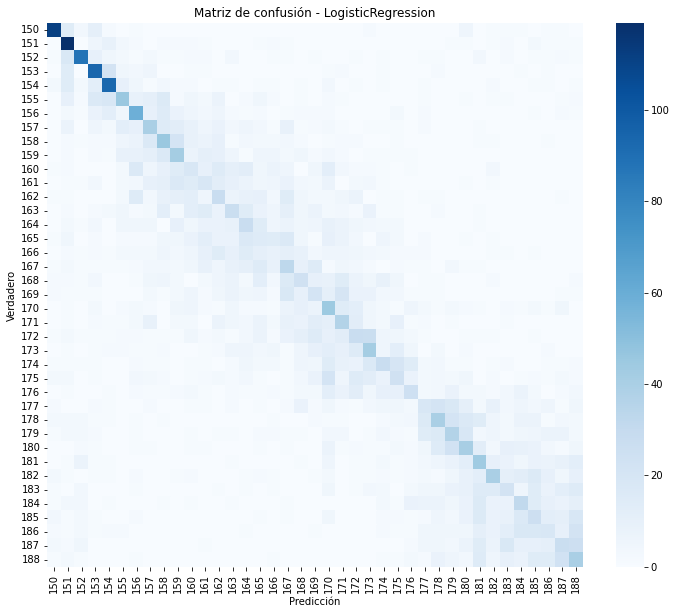

In [12]:
# ==========================
# 6) Matriz de confusión del mejor modelo
# ==========================
print(f"\n=== Mejor modelo: {best_name} con F1_macro={best_score:.4f} ===")

y_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_best, labels=np.unique(y))
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=False, cmap="Blues", fmt="d",
    xticklabels=np.unique(y), yticklabels=np.unique(y)
)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title(f"Matriz de confusión - {best_name}")
plt.show()

In [13]:
# ==========================
# 7) Guardar mejor modelo
# ==========================
joblib.dump(best_model, "best_decade_model.joblib")
print("✅ Mejor modelo guardado en best_decade_model.joblib")



✅ Mejor modelo guardado en best_decade_model.joblib


In [14]:
# ==========================
# 8) Predicción en eval.csv (solo predicción, no entrenamiento)
# ==========================
df_eval = pd.read_csv("eval.csv")  # columnas: id,text
df_eval["text_clean"] = df_eval["text"].apply(clean_text)

X_eval = df_eval["text_clean"].values
preds = best_model.predict(X_eval)

In [15]:
# ==========================
# 9) Exportar submission.csv
# ==========================
df_out = pd.DataFrame({
    "id": df_eval["id"],
    "answer": preds
})
df_out.to_csv("submission.csv", index=False)
print("📁 Archivo de predicciones guardado en submission.csv para Kaggle")

📁 Archivo de predicciones guardado en submission.csv para Kaggle
